In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer
)

sns.set(style="darkgrid")

In [2]:
def read_file(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

def save_file(file, path):
    with open(path, "w") as f:
        for line in file:
            f.write(line + "\n")

def calculate_lengths(lines):
    lengths = [len(line.split()) for line in lines]
    return lengths

In [3]:
de = read_file("../data/clean/clean.de")
en = read_file("../data/clean/clean.en")

In [4]:
de_lens = calculate_lengths(de)
en_lens = calculate_lengths(en)

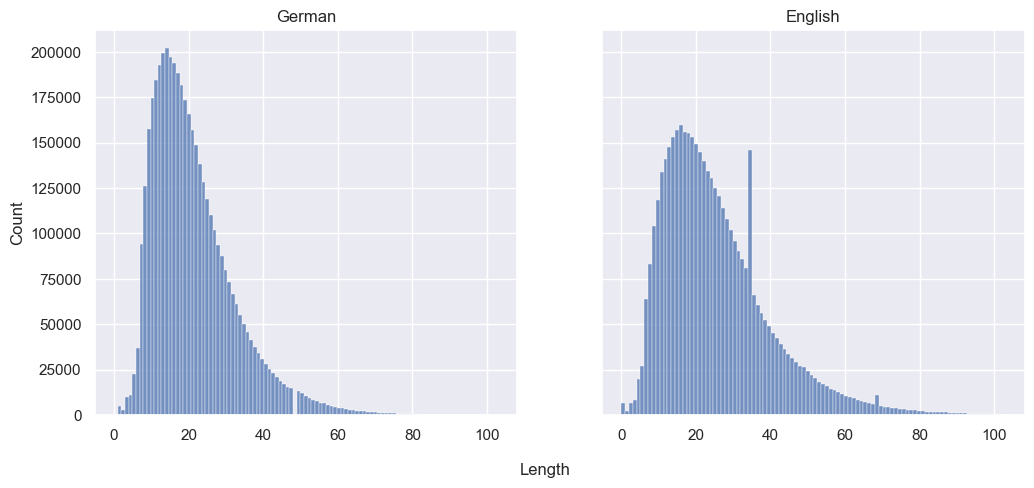

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
sns.histplot(de_lens, bins=100, ax=ax1)
ax1.set_title("German")
sns.histplot(en_lens, bins=100, ax=ax2)
ax2.set_title("English")
fig.text(0.5, -0.01, "Length", ha="center", fontsize=12)
plt.show()

In [6]:
print("German")
print(f"Mean: {np.mean(de_lens):.2f}")
print(f"Median: {np.median(de_lens):.2f}")
print(f"Max: {np.max(de_lens):.2f}")
print(f"Min: {np.min(de_lens):.2f}")
print(f"Std: {np.std(de_lens):.2f}")
print()
print("English")
print(f"Mean: {np.mean(en_lens):.2f}")
print(f"Median: {np.median(en_lens):.2f}")
print(f"Max: {np.max(en_lens):.2f}")
print(f"Min: {np.min(en_lens):.2f}")
print(f"Std: {np.std(en_lens):.2f}")

German
Mean: 21.20
Median: 19.00
Max: 98.00
Min: 0.00
Std: 11.24

English
Mean: 25.59
Median: 23.00
Max: 103.00
Min: 0.00
Std: 14.30


In [27]:
21.20 + 3*11.24, 25.59 + 3*14.30

(54.92, 68.49000000000001)

In [4]:
### German ###

de_words = [word for line in de for word in line.split()]
de_counter = Counter(de_words)
len(de_counter)

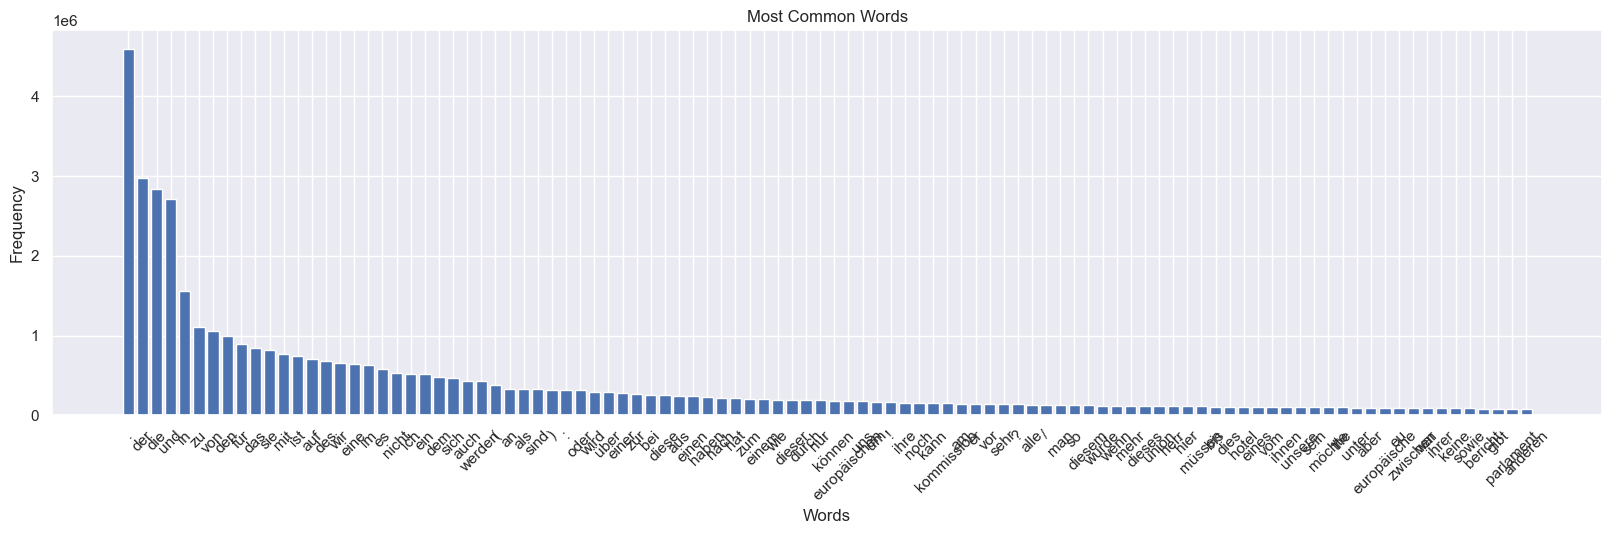

In [15]:
most_common = de_counter.most_common(100)
words = [word for word, count in most_common]
frequencies = [count for word, count in most_common]

plt.figure(figsize=(20, 5))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.show()

In [7]:
sorted_counter = de_counter.most_common()

with open('de_counter.txt', 'w') as file:
    for item in sorted_counter:
        file.write(f'{item[0]}: {item[1]}\n')

In [4]:
### English ###

en_words = [word for line in en for word in line.split()]
en_counter = Counter(en_words)
len(en_counter)

685638

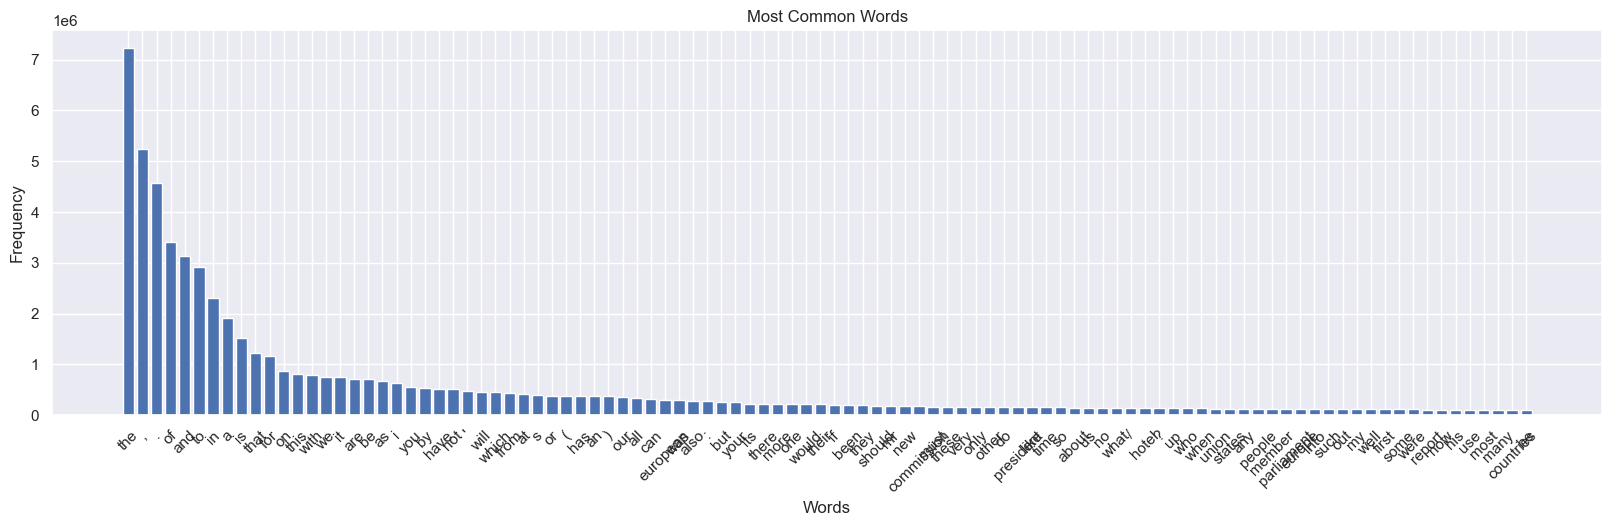

In [5]:
most_common = en_counter.most_common(100)
words = [word for word, count in most_common]
frequencies = [count for word, count in most_common]

plt.figure(figsize=(20, 5))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.show()

In [7]:
sorted_counter = en_counter.most_common()

with open('en_counter.txt', 'w') as file:
    for item in sorted_counter:
        file.write(f'{item[0]}: {item[1]}\n')

In [26]:
def create_tokenizer(txt, vocab_size, limit_alph=30, init_alph=[]):
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    tokenizer.normalizer = normalizers.Sequence([normalizers.Lowercase()])
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
        pre_tokenizers.Digits(individual_digits=True),
        pre_tokenizers.Whitespace()
    ])
    special_tokens = ["[PAD]", "[UNK]", "[SOS]", "[EOS]"]
    trainer = trainers.WordPieceTrainer(
        vocab_size=vocab_size, 
        special_tokens=special_tokens,
        initial_alphabet=init_alph,
        limit_alphabet=limit_alph
    )
    tokenizer.decoder = decoders.WordPiece(prefix="##")
    tokenizer.train_from_iterator(txt, trainer)

    sos_token = tokenizer.token_to_id("[SOS]")
    eos_token = tokenizer.token_to_id("[EOS]")
    tokenizer.post_processor = processors.TemplateProcessing(
        single=f"[SOS]:0 $A:0 [EOS]:0",
        special_tokens=[("[SOS]", sos_token), ("[EOS]", eos_token)],
    )
    return tokenizer

In [27]:
initial_alphabet = list("abcdefghijklmnopqrstuvwxyzßäöü1234567890().,/:;?!'^#$%")

In [28]:
tok = create_tokenizer(de, 10_000, init_alph=initial_alphabet, limit_alph=len(initial_alphabet))

In [29]:
tok.save("de_tokenizer_10000.json")

In [5]:
de_tok = Tokenizer.from_file("../tokenizers/de_tokenizer_10000.json")
en_tok = Tokenizer.from_file("../tokenizers/en_tokenizer_10000.json")

In [6]:
de_counter = Counter()
de_lengths = []
en_counter = Counter()
en_lengths = []

for de_string, en_string in tqdm(zip(de, en), total=len(de), desc="Counting", ncols=100):
    de_tokens = de_tok.encode(de_string).tokens
    de_counter.update(de_tokens)
    de_lengths.append(len(de_tokens))

    en_tokens = en_tok.encode(en_string).tokens
    en_counter.update(en_tokens)
    en_lengths.append(len(en_tokens))

de_word_count = dict(de_counter.most_common())
en_word_count = dict(en_counter.most_common())

Counting: 100%|█████████████████████████████████████████| 4468840/4468840 [11:05<00:00, 6711.57it/s]


In [7]:
# Vocab 20000:
# German [UNK] tokens: 0.23 %
# English [UNK] tokens: 0.29 %

# Vocab 10000:
# German [UNK] tokens: 0.21 %
# English [UNK] tokens: 0.27 %

print("German [UNK] tokens: {:.2f} %".format(de_word_count["[UNK]"] / sum(de_word_count.values()) * 100))
print("English [UNK] tokens: {:.2f} %".format(en_word_count["[UNK]"] / sum(de_word_count.values()) * 100))

German [UNK] tokens: 0.21 %
English [UNK] tokens: 0.27 %


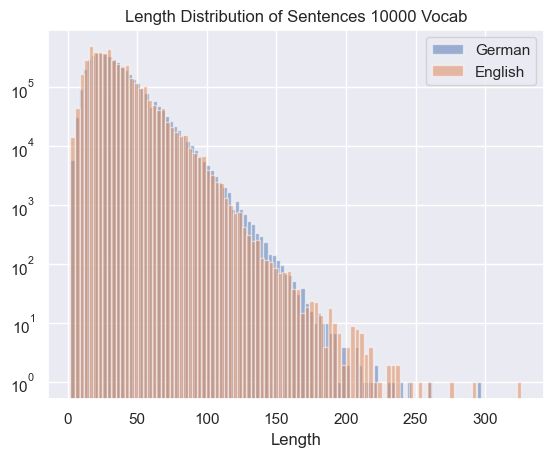

In [33]:
plt.hist(de_lengths, bins=100 ,log=True, label='German', alpha=0.5)
plt.hist(en_lengths, bins=100 ,log=True, label='English', alpha=0.5)
plt.xlabel('Length')
plt.title(f'Length Distribution of Sentences {en_tok.get_vocab_size()} Vocab')
plt.legend()
plt.savefig(f'../plots/en-de-dist-{en_tok.get_vocab_size()}-log.png')
plt.show()

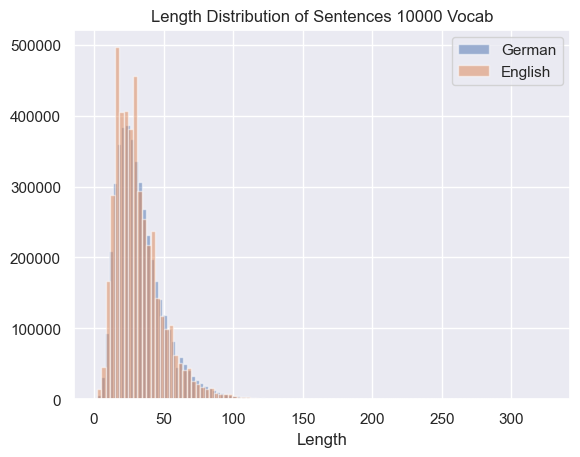

In [16]:
plt.hist(de_lengths, bins=100, label='German', alpha=0.5)
plt.hist(en_lengths, bins=100, label='English', alpha=0.5)
plt.xlabel('Length')
plt.title(f'Length Distribution of Sentences {en_tok.get_vocab_size()} Vocab')
plt.legend()
plt.savefig(f'../plots/en-de-dist-{en_tok.get_vocab_size()}.png')
plt.show()

In [35]:
de_unk_total = []
en_unk_total = []
de_lengths = []
en_lengths = []
for de_string, en_string in tqdm(zip(de, en), total=len(en), desc="Counting", ncols=100):
    de_tokens = de_tok.encode(de_string).tokens
    de_unk = de_tokens.count("[UNK]")
    de_lengths.append(len(de_tokens))
    de_unk_total.append(de_unk)

    en_tokens = en_tok.encode(en_string).tokens
    en_unk = en_tokens.count("[UNK]")
    en_lengths.append(len(en_tokens))
    en_unk_total.append(en_unk)

Counting: 100%|█████████████████████████████████████████| 4468840/4468840 [10:13<00:00, 7289.07it/s]


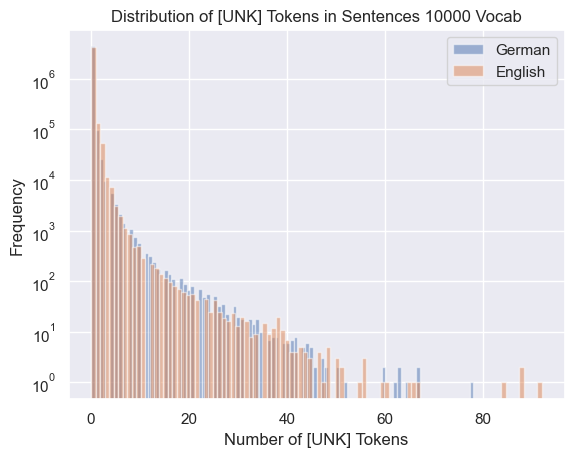

In [36]:
plt.hist(de_unk_total, bins=100, log=True, label='German', alpha=0.5)
plt.hist(en_unk_total, bins=100, log=True, label='English', alpha=0.5)
plt.xlabel('Number of [UNK] Tokens')
plt.ylabel('Frequency')
plt.title(f'Distribution of [UNK] Tokens in Sentences {en_tok.get_vocab_size()} Vocab')
plt.legend()
plt.savefig(f'../plots/en-de-unk-{en_tok.get_vocab_size()}-log.png')
plt.show()

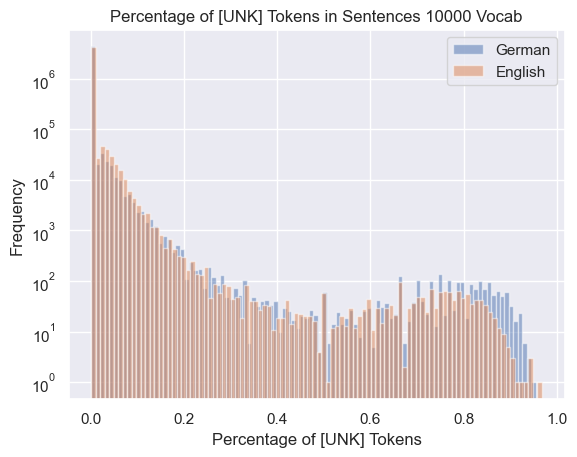

In [37]:
plt.hist(np.array(de_unk_total)/np.array(de_lengths), bins=100, log=True, label='German', alpha=0.5)
plt.hist(np.array(en_unk_total)/np.array(en_lengths), bins=100, log=True, label='English', alpha=0.5)
plt.xlabel('Percentage of [UNK] Tokens')
plt.ylabel('Frequency')
plt.title(f'Percentage of [UNK] Tokens in Sentences {en_tok.get_vocab_size()} Vocab')
plt.legend()
plt.savefig(f'../plots/en-de-unk-perc-{en_tok.get_vocab_size()}-log.png')
plt.show()

In [26]:
def split_data(src, tgt, ratios, shuffle=True, random_state=2018):
    train, dev, test = ratios
    train_src, rest_src, train_tgt, rest_tgt = train_test_split(
        src, tgt, 
        train_size=train, 
        shuffle=shuffle,
        random_state=random_state
    )
    split = test / (test + dev)
    test_src, dev_src, test_tgt, dev_tgt = train_test_split(
        rest_src, rest_tgt, 
        train_size=split, 
        shuffle=shuffle,
        random_state=random_state
    )
    return (train_src, train_tgt), (dev_src, dev_tgt), (test_src, test_tgt)

In [38]:
(train_de, train_en), (dev_de, dev_en), (test_de, test_en) = split_data(de, en, [0.7, 0.15, 0.15])

In [40]:
save_file(train_de, "../data/train/train.de")
save_file(train_en, "../data/train/train.en")
save_file(dev_de, "../data/dev/dev.de")
save_file(dev_en, "../data/dev/dev.en")
save_file(test_de, "../data/test/test.de")
save_file(test_en, "../data/test/test.en")